# Self-Driving Car Engineer Nanodegree

## Vehicle Detection and Tracking

### Overview

The objective of this project is to detect and track vehicles by writing a software pipeline that use computer vision, machine learning techniques such as teh histogram of oriented gradients (HOG) and supervised classifier (support vector machines (SVM)). 
The first portion of the project is to train a vehicle classification model using Linear support vector machine algorithm; extract data image features using histogram of oriented gradients, color histograms, and special binning techniques; The second portion of project is to extract image patches from raw images using sliding window algorithm, these image patches were then used to be extracted features. Then processed features were used as the input argument for the machine learning model. 
The trained SVM model will ouput the indicator of whether the given image patch is a vehicle or non-vehicle. Finally, duplicate detections and false positives would be removed, bounding boxes were drawn to indicate identified vehicle on raw image or video frames.

### Dependencies

- [OpenCV] (http://opencv.org/)
- [Scikit-Learn] (http://scikit-learn.org)
- [Numpy] (http://www.numpy.org/)
- [Matplotlib] (http://matplotlib.org/)
- [SciPy] (https://www.scipy.org/)
- [MoviePy] (https://zulko.github.io/moviepy/)

### Run the Application

`vehicle_detection_tracking.py`

## Project Implementation

### Vehicle Detection and Tracking Pipeline

The following picture illustrates the vehicle detection and tracking pipeline in this project. 

![png](images/pipeline.png)

Here are the breakdown steps of the pipeline.

#### Sliding Windows

The vehicle detection pipeline starts with the sliding window, which basically convolves a small rectangle search window on images to extract image patches. The sliding window algorithm takes the width, height of the window, and the overlap between windows as input arguments. In this project, a combine of specific window width, height and overlap are used for robustness.

- `window size` : (96, 96)
- `overlap` : (0.75, 0.75)
- `horizontal start and stop index` : Not specified    
- `vertical start and stop index` : [400, 600] (as vehicles are most likely to be appear at the bottom section of images)

In [1]:
# First, import useful utilities and libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import *
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from moviepy.editor import VideoFileClip

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Plot random raw images of vehicles and non-vehicles
vehicle_files, vehicle_images = detector.extract_files_images('./data/vehicles/')
non_vehicle_files, non_vehicle_images = detector.extract_files_images('./data/non-vehicles/')

OUTPUT_LOCATION = './images/'

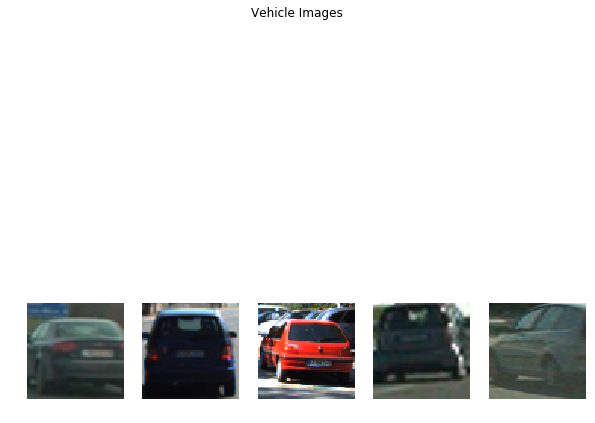

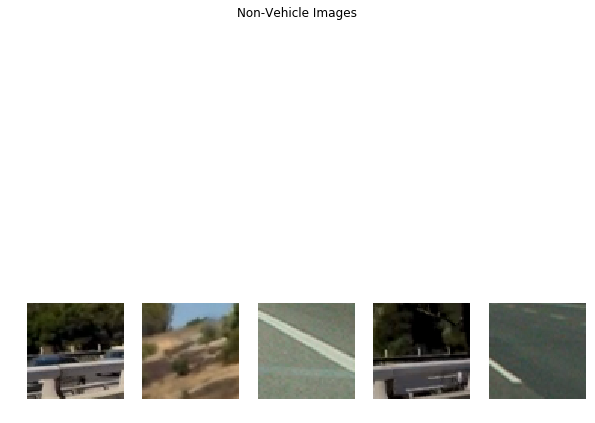

In [3]:
plt.figure(figsize=(10,10))
for i in range(5):
    rnd_idx = np.random.randint(1, len(vehicle_files))
    plt.subplot(1,5,i+1)
    plt.imshow(vehicle_images[rnd_idx])
    plt.axis('off')
plt.suptitle('Vehicle Images')
plt.savefig(OUTPUT_LOCATION + 'vehicle.png')
plt.show()

plt.figure(figsize=(10,10))
for i in range(5):
    rnd_idx = np.random.randint(1, len(non_vehicle_files))
    plt.subplot(1,5,i+1)
    plt.imshow(non_vehicle_images[rnd_idx])
    plt.axis('off')
plt.suptitle('Non-Vehicle Images')
plt.savefig(OUTPUT_LOCATION + 'non_vehicle.png')
plt.show()

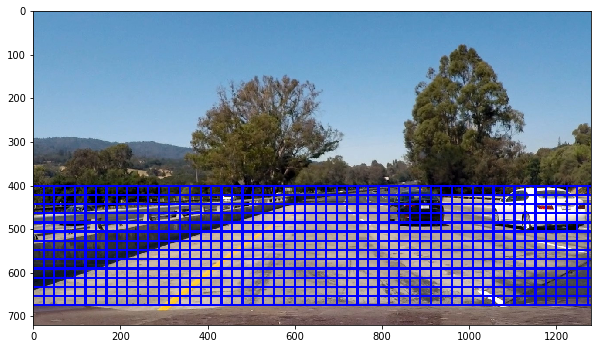

In [4]:
# The following image shows the location of the search windows.
image = './test_images/test1.jpg'
image = mpimg.imread(image)
copy_image = np.copy(image)

windows = detector.slide_window(copy_image, xy_window=(96, 85), xy_overlap=(0.75, 0.75), y_start_stop=[400, 650])
def draw_sliding_windows(image, windows):
    for window in windows:
        cv2.rectangle(image, window[0], window[1], (0, 0, 255), 3)
    return image
img = draw_sliding_windows(image, windows)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.savefig(OUTPUT_LOCATION + 'slided_windows.png')
plt.show()

#### Feature Extraction

Regarding the feature extraction methods, three methods are mainly used in this project:

1. Histogram of Oriented Gradients (HOG)
    a. `orient` 9
    b. `pix_per_cell` 8
    c. `cell_per_block` 2
    d. `color_space` YCrCb
2. Spatial Binning
    a. `nbins` 32
3. Color Histograms
    a. `color_hist` 32

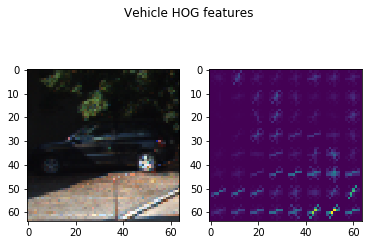

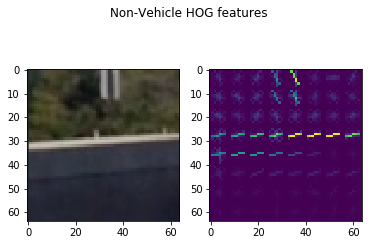

In [5]:
# HOG
vehicles = []
vehicles_hog_features = []
# Vehicle HOG features
rnd_idx = np.random.randint(1, len(vehicle_files))
image = mpimg.imread(vehicle_files[rnd_idx])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features, hog_image = detector.get_hog_features(gray, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image, cmap=None)
plt.subplot(1,2,2)
plt.imshow(hog_image, cmap=None)
plt.suptitle('Vehicle HOG features')
plt.savefig(OUTPUT_LOCATION + 'vehicles_hog.png')
plt.show()

# Non-vehicle HOG features
rnd_idx = np.random.randint(1, len(non_vehicle_files))
image = mpimg.imread(non_vehicle_files[rnd_idx])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features, hog_image = detector.get_hog_features(gray, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=False)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(image, cmap=None)
plt.subplot(1,2,2)
plt.imshow(hog_image, cmap=None)
plt.suptitle('Non-Vehicle HOG features')
plt.savefig(OUTPUT_LOCATION + 'non_vehicle_hog.png')
plt.show()

#### Training the Machine Learning Model

The linear Support Vector Machine was selected for classifier. A hyper-parameter optimization method was used to help find the best parameters for SVC. The following are the optimized hyper_parameter values that were finally used for Linear SVM model.

- `penalty` l2
- `C` 0.08
- `loss` hinge

In [6]:
# Config the parameters for Support Vector Machine Classifier
clf_parameters = {'color_space':'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
				'orient':9, # HOG orientations
				'pix_per_cell':8, # HOG pixels per cell
				'cell_per_block':2, # HOG cells per block
				'hog_channel':'ALL', # Can be 0, 1, 2, or 'ALL'
				'spatial_size':(32,32), # Spatial binning dimensions
				'hist_bins':32, # Number of histogram bins
				'spatial_feat':True, # Spatial features on or off
				'hist_feat':True, # Histogram features on or off
				'hog_feat':True # HOG features on or off
				}

# Extract vehicle features
vehicle_features = detector.extract_features(vehicle_images, clf_parameters['color_space'], clf_parameters['orient'], \
									clf_parameters['spatial_size'], clf_parameters['hist_bins'], clf_parameters['pix_per_cell'], \
									clf_parameters['cell_per_block'], clf_parameters['spatial_feat'], clf_parameters['hist_feat'], \
									clf_parameters['hog_feat'], clf_parameters['hog_channel'])

print('Size of the vehicle features: {}'.format(vehicle_features.shape))

# Extract non-vehicle features
non_vehicle_features = detector.extract_features(non_vehicle_images, clf_parameters['color_space'], clf_parameters['orient'], \
										clf_parameters['spatial_size'], clf_parameters['hist_bins'], clf_parameters['pix_per_cell'], \
										clf_parameters['cell_per_block'], clf_parameters['spatial_feat'], clf_parameters['hist_feat'], \
										clf_parameters['hog_feat'], clf_parameters['hog_channel'])

print('Size of the non-vehicle features: {}'.format(non_vehicle_features.shape))

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
# Create the labels vectors
y = np.hstack((np.ones(len(vehicle_images)), np.zeros(len(non_vehicle_images))))

# Cross validate classifier
C, loss = detector.cross_validation(X, y)

Size of the vehicle features: (8792, 8460)
Size of the non-vehicle features: (8968, 8460)
Validation accuracy: 0.9882 with C: 0.02, loss: hinge
Validation accuracy: 0.9882 with C: 0.08, loss: hinge
Validation accuracy: 0.9882 with C: 0.4, loss: hinge
Validation accuracy: 0.9882 with C: 1.0, loss: hinge
Validation accuracy: 0.9882 with C: 1.4, loss: hinge
Validation accuracy: 0.9884 with C: 0.02, loss: squared_hinge
Validation accuracy: 0.9882 with C: 0.08, loss: squared_hinge
Validation accuracy: 0.9882 with C: 0.4, loss: squared_hinge
Validation accuracy: 0.9882 with C: 1.0, loss: squared_hinge
Validation accuracy: 0.9882 with C: 1.4, loss: squared_hinge
The optimized validation accuracy is: 0.9884 with parameters: C: 0.02, loss: squared_hinge


#### Removing False Positives and Duplicate Detections

After performing the feature extraction and training the Linear SVC model, then we need to deal with the duplicate detections and false positive detections. The following plot shows the multiple detections on test image and the heat-map.

In [7]:
# Normalize data features
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

# Create Linear Support Vector Classifier
#clf = LinearSVC(C=C, penalty='l2', loss=loss).fit(X, y)
clf = LinearSVC(C=0.08, penalty='l2', loss='hinge').fit(X, y)

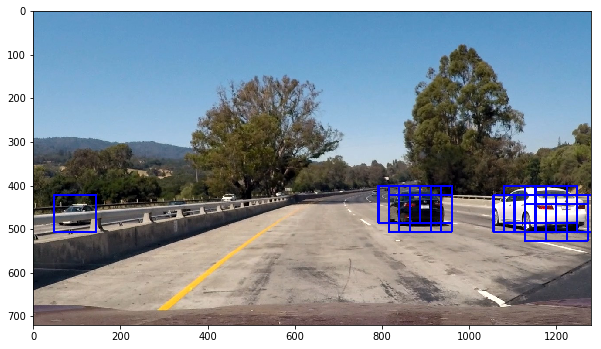

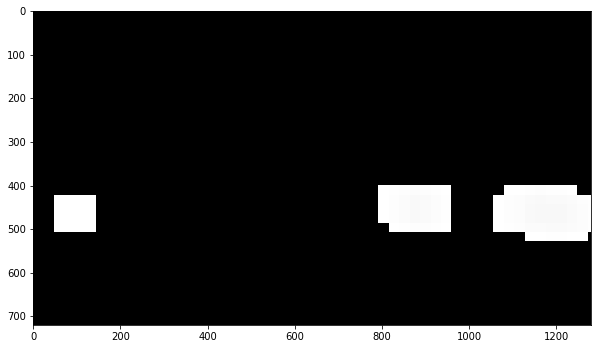

In [8]:
img_path = './test_images/test1.jpg'
image = mpimg.imread(img_path)
copy_image = np.copy(image)
draw_image = np.copy(image)
image = image.astype(np.float32)/255.0

slided_windows = detector.slide_window(image, [None, None], [400, 600], (96,85), (0.75, 0.75))
#slided_windows = detector.slide_window(image)

on_windows = detector.search_windows(image, slided_windows, clf, scaler, \
							clf_parameters['color_space'], clf_parameters['spatial_size'], clf_parameters['hist_bins'], \
							clf_parameters['orient'], clf_parameters['pix_per_cell'], clf_parameters['cell_per_block'], \
							clf_parameters['hog_channel'], clf_parameters['spatial_feat'], clf_parameters['hist_feat'], \
							clf_parameters['hog_feat'])

window_img = detector.draw_boxes(draw_image, on_windows, color=(0, 0, 255), thick=3)

plt.figure(figsize=(10,10))
plt.imshow(window_img)
plt.savefig(OUTPUT_LOCATION + 'draw_boxes.png')
plt.show()

heat_map = np.zeros_like(image)
heat_map = detector.add_heat(heat_map, on_windows)

plt.figure(figsize=(10,10))
plt.imshow(heat_map, cmap='hot')
plt.savefig(OUTPUT_LOCATION + 'heat_map.png')
plt.show()

The heat-map would be used to remove both the duplicate detections and false positives.

 - Create a image holder with dimension being equivalent to the input image dimension
 - Add heat for all pixels inside of windows that is identified as a positive detection by SVC, `add_heat`
 - Reject and remove false positives by applying a threshold, `apply_threshold`
 
In addition to the two functions above, there is a simple smoothness method that has been applied. Basically, a list holder is created `self.frames` to store the last 25 video frames heat_maps processed by `add_heat`, then frames sums them up and pass to `apply_threshold` to filter out the false positives and multiple detections. This method should make the heat_map thresholding more robust as it is processed as a unit of 25 video frames, instead of one.

## Output

All the utilities or member functions mentioned above are encapsulated into a class `detector` as either normal member function, static method or class method. This should give user a more friendly use interface by simply creating an instance of class object.

Here is the final processed road image.

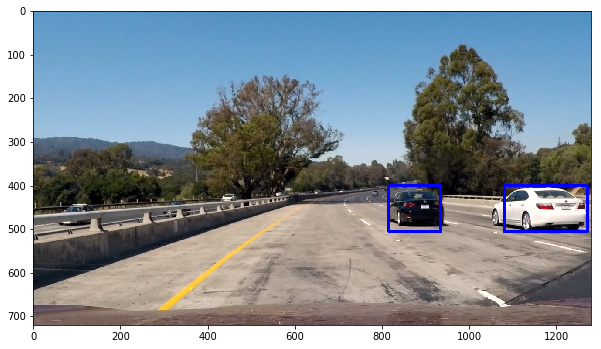

In [9]:
# Create instance of vehicle detection and tracking
detector_ins = detector(clf_parameters=clf_parameters, scaler=scaler, classifier=clf)

image_path = './test_images/test1.jpg'
image = mpimg.imread(image_path)
output = detector_ins.detect(image)
plt.figure(figsize=(10,10))
plt.imshow(output)
plt.savefig(OUTPUT_LOCATION + 'output.png')
plt.show()

## Conclusions, Analysis and Improvements

The main object of this project is to get ourselves familiar with using the computer vision and conventional machine learning techniques to perform the vehicle detection and tracking. The HOG and spatial binning are used for road images feature extraction. Linear Support Vector Machine classifier is used for object detection model.

The biggest drawback of the project is its performance efficiency, even though it works fairly well on the project video. The feature extraction portion consumes most of the computation power, and there should be improvement in the future to try out other alternative methods. In addition to the linear SVM, other machine learning or deep learning models are definitely worthy of implementing and commissioning in this project.